# Import Libraries

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import time

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

In [16]:
# Initialisierungen
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed
tf.reset_default_graph()
image_size = 512
train_path = "dataset/Lung Segmentation/"

# Datensatz herunterladen

url = 'https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels/download/chest-xray-masks-and-labels.zip'

Lade den Datensatz herunter und platziere ihn im 'dataset/' ordner und benenne es in "Lung Segmentation" um. 

Der Datensatz muss so aussehen: "dataset/Lung Segmentation/"


# Prepare Dataset

Der Datensatz enthält Röntgenbilder und entsprechende Masken. Einige Masken fehlen, daher werden die Bilder und Masken miteinander verknüpfen.

In [3]:
def prepare_data(path):
    images_path = os.path.join(path, "CXR_png/")
    images = os.listdir(images_path)
    os.makedirs("dataset/Lung Segmentation/image")
    os.makedirs("dataset/Lung Segmentation/mask")
    for img in images:
        filename, file_extension = os.path.splitext(img)
        print(filename)
        image = os.path.join(path, "CXR_png/", filename) + ".png"
        mask = os.path.join(path, "masks/", filename+'_mask') + ".png"
        if os.path.isfile(mask):
            im = cv2.imread(image, -1)
            print('Original image size: ', im.shape)
            im = cv2.resize(im, (image_size,image_size))
            print('Resized image size: ', im.shape)
            cv2.imwrite("dataset/Lung Segmentation/image/{}.png".format(filename), im)
            ms = cv2.imread(mask, -1)
            ms = cv2.resize(ms, (image_size, image_size))
            cv2.imwrite("dataset/Lung Segmentation/mask/{}.png".format(filename), ms)

if not os.path.exists('dataset/Lung Segmentation/image'):
    prepare_data(train_path)


# Loading Data as Tensor using Keras Datagenerator

Die Python-Klasse "DataGen" wird für die Echtzeitdateneingabe in unser Keras-Modell verwendet.

Wir setzen Argumente in die Method "__init__" als relevante Informationen zu den Daten, wie z. B. Dimensionsgrößen, Anzahl der Kanäle, Anzahl der Klassen, Batchsize, oder entscheiden, ob wir unsere Daten bei der Generierung mischen möchten(shuffle). Wir speichern auch wichtige Informationen wie Etiketten und die Liste der IDs, die wir bei jedem Durchgang generieren möchten.

Wenn in der Methode "on_epoch_end" der Parameter "shuffle" auf "True" gesetzt ist, erhalten wir bei jedem Durchgang eine neue Erkundungsreihenfolge. Das Mischen der Reihenfolge, in der die Beispiele dem Klassifikator zugeführt werden, ist hilfreich, damit die Batches zwischen den Epochen nicht gleich aussehen. Dadurch wird unser Modell möglicherweise robuster.

Die Funktion "_load_" bereitet unsere Daten(das Bild und entsprechende Maske) anhand unserer Datenbank auf, um sie in das Netzwerk einzufügen.

"_data_generation" Method verwendet die Liste der IDs des Ziel-Batches als Argument und erzeugt Batch-Daten.

"_len_" Bezeichnet die Anzahl der Batches pro Epoche.

Wenn nun der einem bestimmten Index entsprechende Batchgröße aufgerufen wird, führt der Generator die Methode "__getitem__" aus, um die benötigte Daten als Eingabe-Tensors zu generieren.

Auf diese Weise generieren wir unsere Eingabedaten als Tensoren, um das Modell zu füttern.

In [4]:
"""### Keras Datagenerator ###"""

class DataGen(keras.utils.Sequence):
    # The initialization function of the class.
    def __init__(self, ids, path, batch_size=8, image_size=512, shuffle=True):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __load__(self, id_name):
        filename, file_extension = os.path.splitext(id_name)
        image_path = os.path.join(self.path, "image/", filename) + ".png"
        mask_path = os.path.join(self.path, "mask/", filename) + ".png"
        image = cv2.imread(image_path, 0)  # read image - 1 for RGB format
        image = cv2.resize(image, (self.image_size, self.image_size))  # resize image to a specific size 512x512
        mask_image = cv2.imread(mask_path, 0)  # read Grayscale mask
        mask_image = cv2.resize(mask_image, (self.image_size, self.image_size))  # resize mask to a specific size 512x512
        image = np.expand_dims(image, axis=-1)
        mask = np.expand_dims(mask_image, axis=-1)
        # normalize the image and mask
        image = image / 255.0
        mask = mask / 255.0
        return image, mask

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index * self.batch_size
        files_batch = self.ids[index * self.batch_size: (index + 1) * self.batch_size]
        image = []
        mask = []
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
        image = np.array(image)
        mask = np.array(mask)
        return image, mask

    # A funktion to set random exploration of dataset
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids) / float(self.batch_size)))

# Hyperparameter

Wir trainieren unser Modell für 150 Epochen.
Die Batchgröße ist auf 8 Bilder pro Batch eingestellt.
Da wir nun 566 Bilder als Datensatz zur Verfügung haben, teilen wir diese so auf: 50 Bilder als Validierungsdatensatz, 12 Bilder als Testdatensatz und 504 Bilder als Trainingsdatensatz.

Wir verwenden auch sogenannte Checkpoints, um dazwischen die besten Ergebnisse zu speichern, verwenden wir weiterhin Tensorboard, um den Trainingsprozess zu visualisieren.

In [5]:
epochs = 150
batch_size = 8
train_ids = next(os.walk(train_path+'image/'))[2]
val_data_size = 50
test_data_size = 12
valid_ids = train_ids[:val_data_size]
test_ids = train_ids[val_data_size:(val_data_size+test_data_size)]
train_ids = train_ids[(val_data_size+test_data_size):]

LogName = ("Training_3L_1ch_AvgPool_neu{}".format(int(time.time())))
tensorboard = TensorBoard(log_dir="logs/{}".format(LogName))
checkpoint = ModelCheckpoint("weights/UNet_3L_1ch_AvgPool_best_weights_neu.h5",
                             monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacl_list = [tensorboard, checkpoint]

# Input data visualization


Image: (8, 512, 512, 1) Mask: (8, 512, 512, 1)


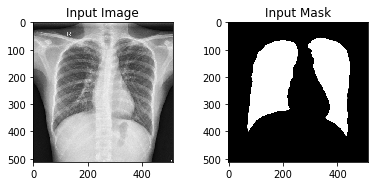

In [6]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)   # start from item 0
print("Image:", x.shape, "Mask:", y.shape)

r = random.randint(0, len(x)-1)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Input Image")
# ax.imshow(x[r])
ax.imshow(np.reshape(x[r], (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 2, 2)
ax.set_title("Input Mask")
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")
plt.show()

# CNN Architecture
hgkugzkug

In [7]:
# Downsampling network from 2x Conv2D + 1 Maxpooling (2x2)
def down_block_same3(x, filters, kernel_size = (3, 3), padding = "same", strides = 1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    # p = keras.layers.MaxPooling2D((2, 2), (2, 2))(c)
    p = keras.layers.AveragePooling2D((2, 2), (2, 2))(c)
    return c, p



# Upsampling network from 1 Upsampling layer + 1 Concatination + 2x Conv2D
def up_block_same3(x, skip, filters, kernel_size = (3, 3), padding = "same", strides = 1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides, activation = "relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides, activation = "relu")(c)
    return c


# Bottleneck
def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

# U-Net Model

O. Ronneberger et al. (2015) haben ein Netzwerk namens U-net geschaffen, das aus zwei Teilen besteht. Ein Vertragsteil zum Berechnen von Merkmalen und ein expandierender Teil zum räumlichen Lokalisieren von Mustern im Bild. Der Downsampling-Teil verfügt über eine FCN-ähnliche Architektur, die Features mit 3x3-Convolutions extrahiert. Der Upsampling-Teil verwendet Up-Convolution (oder Deconvolution), um die Anzahl der Feature-Maps zu reduzieren und gleichzeitig ihre Höhe und Breite zu erhöhen.
Ausgeschnittene Feature-Maps aus dem Downsampling-Teil des Netzwerks werden in den Upsampling-Teil kopiert, um den Verlust von Musterinformationen zu vermeiden. Schließlich verarbeitet eine 1x1-Convolution die Featuremaps, um eine Segmentierungs Maske zu erzeugen und somit jedes Pixel des Eingabebildes zu kategorisieren.

In dieser Implementierung haben wir 3 Downsampling-Layer, einen Bottleneck mit 2 Convolution- und 3 Upsampling-Layer. Wir haben insgesamt 1.077.089 Parameter produziert.

In [8]:
def UNet():
    f = [16, 32, 64, 128, 256, 512, 1024]  # Number of Filters
    inputs = keras.layers.Input((image_size, image_size, 1))

    p0 = inputs  # Input image 512x512
    c1, p1 = down_block_same3(p0, f[0])  # 512 -> 256
    c2, p2 = down_block_same3(p1, f[1])  # 256 -> 128
    c3, p3 = down_block_same3(p2, f[2])  # 128 -> 64
    # c4, p4 = down_block_same3(p3, f[3])  # 64  -> 32
    # c5, p5 = down_block_same3(p4, f[4])  # 32  -> 16
    # c6, p6 = down_block_same3(p5, f[5])  # 16  -> 8

    bn = bottleneck(p3, f[4])

    # u1 = up_block_same3(bn, c6, f[5])   # 8   -> 16
    # u2 = up_block_same3(u1, c5, f[4])   # 16  -> 32
    # u3 = up_block_same3(u2, c4, f[3])   # 32  -> 64
    u4 = up_block_same3(bn, c3, f[2])   # 64  -> 128
    u5 = up_block_same3(u4, c2, f[1])   # 128 -> 256
    u6 = up_block_same3(u5, c1, f[0])   # 256 -> 512

    outputs = keras.layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(u6)
    model = keras.models.Model(inputs, outputs)
    return model

# Compile UNet 

Die Architektur von UNet ist wie folgt:

In [9]:
# Run the model
model = UNet()
# Compile model
keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer='SGD',  metrics=['accuracy'])
model.summary()

# Training the Model
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)   # object1
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)   # object2
test_gen = DataGen(test_ids, train_path, image_size=image_size, batch_size=len(test_ids))

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 256, 256, 16) 0           conv2d_1[0][0]                   
_____________________________________

# Train the model

In [10]:
train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size
test_steps = len(test_ids)
model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps,
                    validation_steps=valid_steps, epochs=epochs, callbacks=callbacl_list)

model.save_weights("weights/UNet_3L_1ch_AvgPool_best_weights_neu.h5")
print("Training done!\nModel saved to disk!")

## Tensorboard Einstellungen ##
with tf.Session() as sess:
    # or creating the writer inside the session
    writer = tf.summary.FileWriter('./graphs', sess.graph) # Visualize the Graph

Instructions for updating:
Use tf.cast instead.
Epoch 1/150
7/7 [==============================] - 2s 242ms/step - loss: 3.9909 - acc: 0.7420

Epoch 00001: val_acc improved from -inf to 0.74195, saving model to weights/UNet_3L_1ch_AvgPool_best_weights_neu.h5
63/63 [==============================] - 27s 433ms/step - loss: 4.6201 - acc: 0.7400 - val_loss: 3.9909 - val_acc: 0.7420
Epoch 2/150
25/25 [==============================] - 1s 34ms/step - loss: 1.1043 - acc: 0.7437

Epoch 00002: val_acc improved from 0.74195 to 0.74366, saving model to weights/UNet_3L_1ch_AvgPool_best_weights_neu.h5
63/63 [==============================] - 24s 373ms/step - loss: 4.4347 - acc: 0.7471 - val_loss: 1.1043 - val_acc: 0.7437
Epoch 3/150
25/25 [==============================] - 1s 34ms/step - loss: 0.9989 - acc: 0.7437

Epoch 00003: val_acc did not improve from 0.74366
63/63 [==============================] - 24s 374ms/step - loss: 4.2947 - acc: 0.7471 - val_loss: 0.9989 - val_acc: 0.7437
Epoch 4/150
25

63/63 [==============================] - 23s 367ms/step - loss: 0.9175 - acc: 0.9580 - val_loss: 0.2138 - val_acc: 0.9612
Epoch 56/150
25/25 [==============================] - 1s 35ms/step - loss: 0.2414 - acc: 0.9533

Epoch 00056: val_acc did not improve from 0.96122
63/63 [==============================] - 23s 366ms/step - loss: 0.9990 - acc: 0.9537 - val_loss: 0.2414 - val_acc: 0.9533
Epoch 57/150
25/25 [==============================] - 1s 33ms/step - loss: 0.3256 - acc: 0.9419

Epoch 00057: val_acc did not improve from 0.96122
63/63 [==============================] - 23s 368ms/step - loss: 0.9412 - acc: 0.9569 - val_loss: 0.3256 - val_acc: 0.9419
Epoch 58/150
25/25 [==============================] - 1s 33ms/step - loss: 0.2014 - acc: 0.9636

Epoch 00058: val_acc improved from 0.96122 to 0.96363, saving model to weights/UNet_3L_1ch_AvgPool_best_weights_neu.h5
63/63 [==============================] - 24s 379ms/step - loss: 0.8902 - acc: 0.9595 - val_loss: 0.2014 - val_acc: 0.9636
Ep

63/63 [==============================] - 23s 371ms/step - loss: 0.6115 - acc: 0.9716 - val_loss: 0.1393 - val_acc: 0.9741
Epoch 114/150
25/25 [==============================] - 1s 33ms/step - loss: 0.1371 - acc: 0.9740

Epoch 00114: val_acc did not improve from 0.97414
63/63 [==============================] - 23s 366ms/step - loss: 0.5823 - acc: 0.9730 - val_loss: 0.1371 - val_acc: 0.9740
Epoch 115/150
25/25 [==============================] - 1s 33ms/step - loss: 0.1401 - acc: 0.9733

Epoch 00115: val_acc did not improve from 0.97414
63/63 [==============================] - 23s 366ms/step - loss: 0.5741 - acc: 0.9733 - val_loss: 0.1401 - val_acc: 0.9733
Epoch 116/150
25/25 [==============================] - 1s 33ms/step - loss: 0.1333 - acc: 0.9746

Epoch 00116: val_acc improved from 0.97414 to 0.97462, saving model to weights/UNet_3L_1ch_AvgPool_best_weights_neu.h5
63/63 [==============================] - 24s 379ms/step - loss: 0.5666 - acc: 0.9737 - val_loss: 0.1333 - val_acc: 0.9746


Epoch 00142: val_acc did not improve from 0.97590
63/63 [==============================] - 23s 372ms/step - loss: 0.5522 - acc: 0.9741 - val_loss: 0.1378 - val_acc: 0.9739
Epoch 143/150
25/25 [==============================] - 1s 33ms/step - loss: 0.1370 - acc: 0.9740

Epoch 00143: val_acc did not improve from 0.97590
63/63 [==============================] - 23s 367ms/step - loss: 0.5310 - acc: 0.9752 - val_loss: 0.1370 - val_acc: 0.9740
Epoch 144/150
25/25 [==============================] - 1s 33ms/step - loss: 0.1385 - acc: 0.9739

Epoch 00144: val_acc did not improve from 0.97590
63/63 [==============================] - 23s 366ms/step - loss: 0.5245 - acc: 0.9753 - val_loss: 0.1385 - val_acc: 0.9739
Epoch 145/150
25/25 [==============================] - 1s 33ms/step - loss: 0.1334 - acc: 0.9748

Epoch 00145: val_acc did not improve from 0.97590
63/63 [==============================] - 23s 372ms/step - loss: 0.5100 - acc: 0.9760 - val_loss: 0.1334 - val_acc: 0.9748
Epoch 146/150
25/

# Using pretrained models weight

In [11]:
model.load_weights("weights/UNet_3L_1ch_AvgPool_best_weights_neu.h5")
print("Weights loaded!")

Weights loaded!


# Visualization

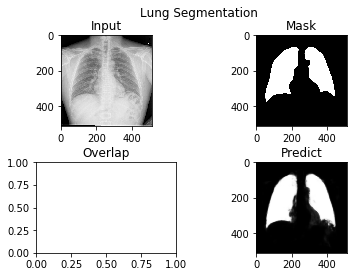

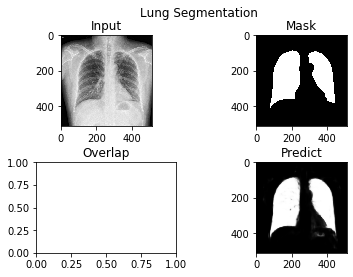

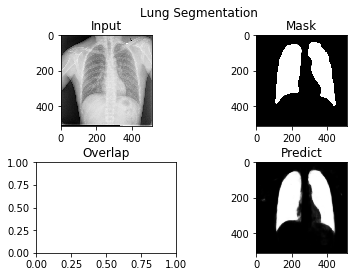

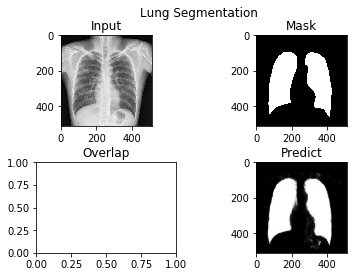

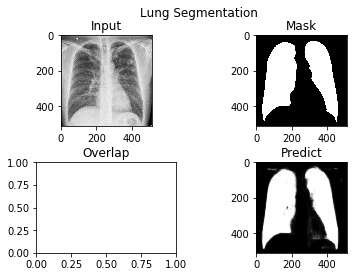

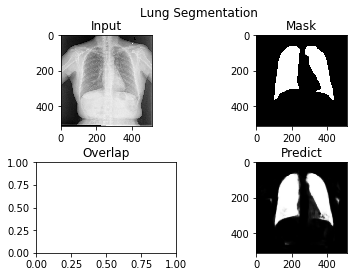

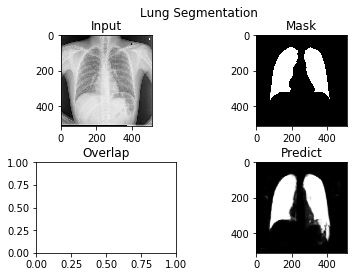

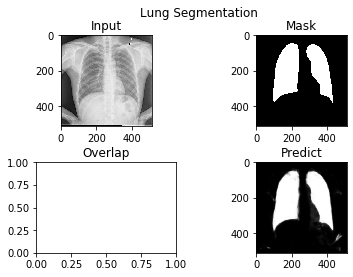

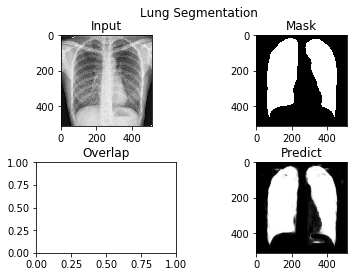

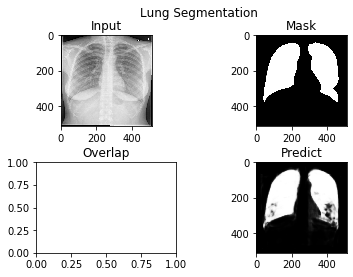

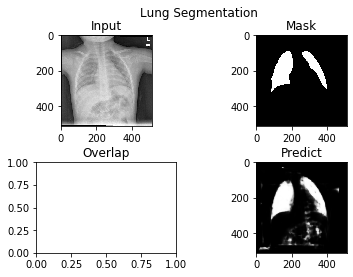

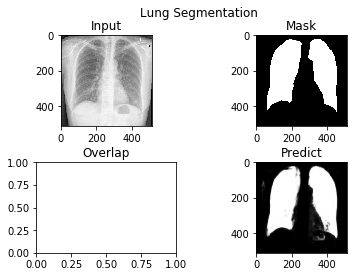

In [12]:
a, b = test_gen.__getitem__(0)
result = model.predict(a)
# result = result > 0.4

for i in range(len(a)):
    fig = plt.figure()
    plt.suptitle('Lung Segmentation')
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    ax = fig.add_subplot(2, 2, 1)
    ax.imshow(np.reshape(a[i]*255, (image_size, image_size)), cmap="gray")
    # ax.imshow(np.reshape(a[i]*255, (image_size, image_size)), cmap="gray")
    ax.set_title("Input")
    ax = fig.add_subplot(2, 2, 2)
    ax.imshow(np.reshape(b[i]*255, (image_size, image_size)), cmap="gray")
    ax.set_title("Mask")
    ax = fig.add_subplot(2, 2, 3)
    ax.set_title("Overlap")
    
    ax = fig.add_subplot(2, 2, 4)
    ax.imshow(np.reshape(result[i]*255, (image_size, image_size)), cmap="gray")
    ax.set_title("Predict")
    fig.savefig("predicts/epoch-{} val-{} batchsize-{} -{}.png".format(epochs,
                                                            val_data_size, batch_size, int(time.time()),i))

plt.show()